In [1]:
import glob
import pylab           as     pl
import pandas          as     pd
import numpy           as     np

from   matplotlib      import pyplot as plt
from   scipy           import stats
from   IPython.display import Image
from   astropy.table   import Table, join, vstack

# *Dark Energy Spectroscopic Instrument*

Today, we continue the legacy of Slipher, Hubble, Vera Rubin et al. with the DESI survey of 30 Million galaxies. 

![title](kittpeak.jpg)

![title](mayall.jpg)

In [2]:
redshifts = Table()

In [3]:
files     = glob.glob('student_andes/zbest-*')

In [4]:
len(files)

3

In [5]:
for file in files:
  redshifts = vstack((redshifts, Table.read(file)))

In [6]:
redshifts

TARGETID,CHI2,COEFF [10],Z,ZERR,ZWARN,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,FLUX_G,FLUX_R,FLUX_Z,DESI_TARGET,BGS_TARGET,MWS_TARGET
int64,float64,float64,float64,float64,int64,bytes6,bytes20,int64,float64,float32,float32,float32,int64,int64,int64
35185923943565589,10152.053012393415,148.86316047472778 .. 5.900162026368106,1.0288177831482437,0.00013716746822282994,0,GALAXY,,10,814.5113570466638,0.5500719,1.43843,7.1975174,0,0,0
35185923951954133,9762.751467436552,209.24160448267065 .. 5.175204196262561,0.6738050981356133,9.294059524252858e-05,0,GALAXY,,10,750.285569190979,1.1057072,6.5002365,28.18528,0,0,0
35185929941419985,9697.200510539114,156.80055757497053 .. -0.2696597294075719,0.5775016610858992,9.57053409911099e-05,0,GALAXY,,10,888.0897645782679,0.67869294,4.1456375,13.65273,0,0,0
35185929949809401,9590.910600095987,141.3364437118511 .. 7.169843778221306,1.0114883070365042,8.625791200718938e-05,0,GALAXY,,10,841.2403792887926,0.2885398,0.77808297,4.705584,0,0,0
35185929949810006,9440.318562611938,123.86145696188387 .. 3.1105691459222404,0.8033843146935814,8.53305757488819e-05,0,GALAXY,,10,798.8345689177513,0.20737517,1.2434902,5.8944407,0,0,0
35185935939272752,10532.481103122234,31.09292018395084 .. 11.769461517129695,0.45524750000706754,3.7363453299701765e-05,0,GALAXY,,10,734.3773981928825,0.72182256,3.5120392,9.9440155,0,0,0
35185935939273421,9735.959887623787,183.3717399095206 .. 6.532384317581797,0.5666153665576416,5.0407523181846655e-05,0,GALAXY,,10,925.3850352242589,0.7689483,4.307138,13.650084,0,0,0
35185935939275488,9064.25718719326,194.12299244026389 .. 6.729941144388765,0.6140468868200675,0.0001576853649057369,0,GALAXY,,10,776.6830798406154,0.6590582,3.7910872,14.436411,0,0,0
35185935939277091,9639.923746824265,-21.85722416051084 .. -5.213298336228368,1.208397771311284,2.936746790437286e-05,0,GALAXY,,10,771.1882997751236,0.60059047,0.7755253,1.5390275,0,0,0


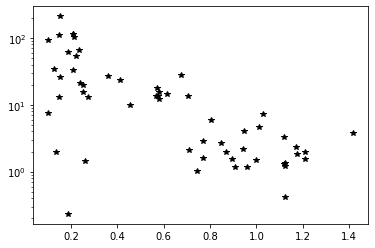

In [8]:
pl.semilogy(redshifts['Z'], redshifts['FLUX_Z'], c='k', marker='*', lw=0.0)